In [2]:
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
import numpy as np
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'sklearn'

In [26]:
#Read in Mike's hpx map with healpy (or it will break)
#Remove the monopole (and dipole) to be closer to an interferometer map
#Upgrade the map to the proper resolution for point-source breakdown (MWA resolution)

map_fits='/Users/nicholebarry/MWA/data/EDA2/EDA2_159MHz_I_wPrior_HPXbin.fits'
map_EDA = hp.read_map(map_fits)

mono = hp.pixelfunc.remove_monopole(map_EDA, nest=False, gal_cut=0, copy=True, verbose=True)
di = hp.pixelfunc.remove_dipole(map_EDA, nest=False, gal_cut=0, copy=True, verbose=True)

mono_up = hp.pixelfunc.ud_grade(mono,2048,order_in='RING')
di_up = hp.pixelfunc.ud_grade(di,2048,order_in='RING')

49152


In [117]:
#Read in the spectral index map
SI_fits='/Users/nicholebarry/MWA/data/EDA2/EDA2prior159_Haslam408_SI_HPXbin.fits'
si_EDA = hp.read_map(SI_fits)

#Calculate the ra, dec of each pixel
pix_inds_subset = arange(hp.nside2npix(64))
l, b = hp.pix2ang(64,pix_inds_subset,lonlat=True)
cel_coords = SkyCoord(l*u.deg, b*u.deg, frame='icrs')
ra_subset = cel_coords.icrs.ra.value
dec_subset = cel_coords.icrs.dec.value

#Find the holes from bright A-team sources and their ra/decs
missing_inds = np.argwhere(si_EDA < 0)
reshaped_missing_inds = missing_inds.reshape(missing_inds.size)
ra_holes = ra_subset[reshaped_missing_inds]
dec_holes = dec_subset[reshaped_missing_inds]

#Prior: there are 9 holes
#Use machine learning to group the ra,decs into 9 groups
n_holes=9
data = list(zip(ra_holes, dec_holes))
kmeans = KMeans(n_clusters=n_holes)
kmeans.fit(data)
      
SI_holes=[]
si_EDA_filled = np.copy(si_EDA)

for hole_i in range(n_holes):
    inds = reshaped_missing_inds[np.argwhere(kmeans.labels_ == hole_i)]
    ra_hole = ra_subset[inds]
    dec_hole = dec_subset[inds]
    around_hole_inds = np.argwhere((ra_subset < (np.amax(ra_hole) + 2.)) & (ra_subset > (np.amin(ra_hole) - 2.)) &
                                   (dec_subset < (np.amax(dec_hole) + 2.)) & (dec_subset > (np.amin(dec_hole) - 2.)) &
                                   (si_EDA > 1))
    SI_holes = np.append(SI_holes, np.average(si_EDA[around_hole_inds]))
    si_EDA_filled[inds] = np.average(si_EDA[around_hole_inds])
    
si_EDA_filled_up = hp.pixelfunc.ud_grade(si_EDA_filled,2048,order_in='RING')
    
outfile = '/Users/nicholebarry/MWA/data/EDA2/EDA2_159-408MHz_SI_wPriori_2049.fits'
hdu = fits.PrimaryHDU(si_EDA_filled_up)
hdu.writeto(outfile)
outfile = '/Users/nicholebarry/MWA/data/EDA2/EDA2_159-408MHz_SI_wPriori.fits'
hdu = fits.PrimaryHDU(si_EDA_filled)
hdu.writeto(outfile)
    

In [112]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
vmin = 1.8
vmax = 3.0

hp.mollview(si_EDA_filled, sub=(2,1,1), fig=fig,title='Spectral Index of Diffuse Emission',min=vmin,max=vmax)
ax2 = fig.add_subplot(2,1,2)
ax2.scatter(ra_subset,dec_subset,c=si_EDA_filled,marker='.',vmin=vmin,vmax=vmax)
ax2.plot(266.416833333,-29.0078055556,'ro',mfc='none',label="Where gal centre should be")
ax2.set_xlabel('RA (deg)')
ax2.set_ylabel('Dec (deg)')
ax2.legend(loc='upper left')

fig.savefig('/Users/nicholebarry/MWA/data/EDA2/si_EDA2_filled.png',bbox_inches='tight')
plt.close()


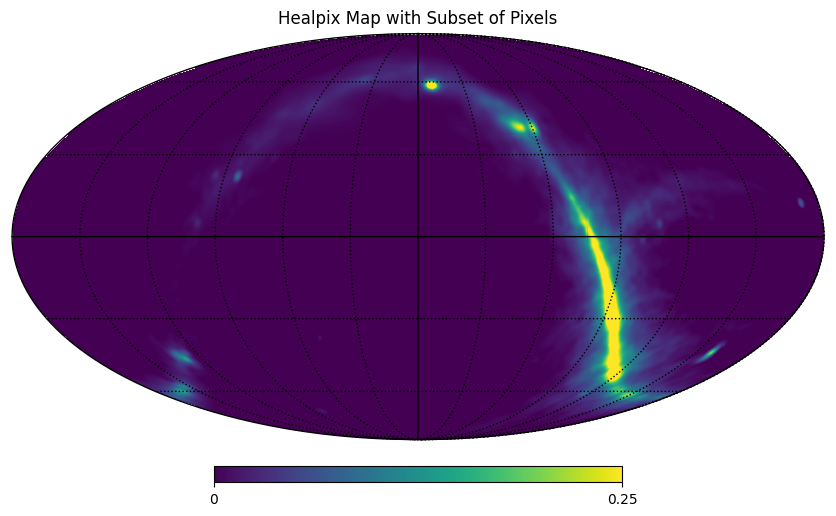

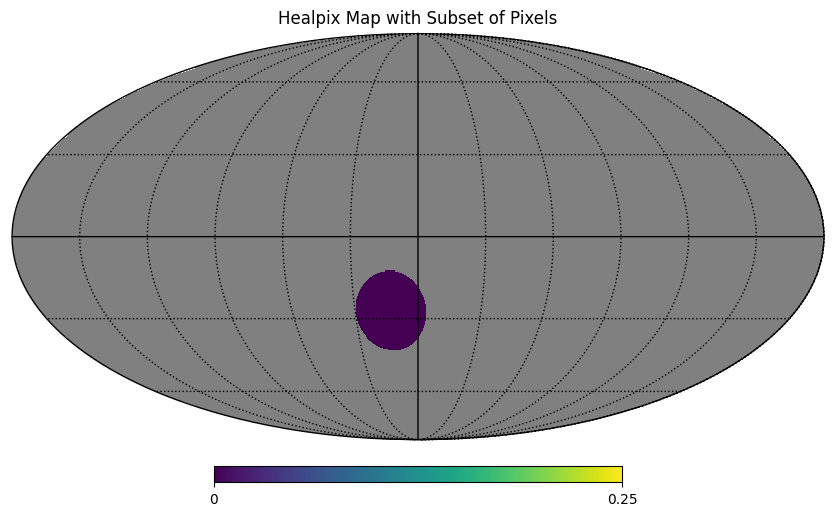

In [8]:
#################### Jack's version

import healpy as hp
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt


map_fits='/Users/z3543600/MWA/data/catalogs/EDA2_prior_mono_2048_si_smoothed.fits'
#map_EDA = hp.read_map(map_fits)
fh = fits.getheader(map_fits)
#data = fits.getdata(map_fits)
hdu_list = fits.open(map_fits)
data = hdu_list[1].data
info = hdu_list[1].header
nside=2048

data = np.array(data)
ra_deg = np.array(data['RA'])
dec_deg = np.array(data['DEC'])
norm_flux_Jy = np.array(data['NORM_COMP_PL'])


# # Example RA and Dec coordinates in degrees
# ra_deg = np.array((hdu_list[1].data))
# dec_deg = np.array([41.269, 22.014, -47.230])
# # Convert RA and Dec from degrees to radians
ra_rad = np.radians(ra_deg)
dec_rad = np.radians(dec_deg)

# # Convert RA and Dec to theta and phi
# # theta = 90 degrees - Dec (in radians)
# # phi = RA (in radians)
theta = np.pi / 2 - dec_rad
phi = ra_rad

# # Define the Healpix resolution parameter (Nside)
# nside = 64  # Example Nside, adjust as needed

# # Get the Healpix pixel indices
pix_indices = hp.ang2pix(nside, theta, phi)


npix = hp.nside2npix(nside)

# Create a full map with all pixels set to np.nan
full_map = np.full(npix, np.nan)

# Assign the subset values to the appropriate positions in the full map
full_map[pix_indices] = norm_flux_Jy

# Plot the map using healpy
hp.mollview(full_map, title="Healpix Map with Subset of Pixels", cmap='viridis', min=0, max=0.25)
hp.graticule()

# pix_inds = np.arange(hp.nside2npix(nside))
l, b = hp.pix2ang(nside,pix_indices,lonlat=True)
cel_coords = SkyCoord(l*u.deg, b*u.deg, frame='icrs')
# ra = cel_coords.icrs.ra.value
# dec = cel_coords.icrs.dec.value
 
l = cel_coords.galactic.l.value
b = cel_coords.galactic.b.value
shift_inds = np.argwhere((l > 180))
l[shift_inds] = l[shift_inds] - 360
galactic_plane_inds = np.argwhere((b < -75) & (b > -95))
#ra_subset = ra_deg[galactic_plane_inds]
#dec_subset = dec_deg[galactic_plane_inds]
data_subset = data[galactic_plane_inds]
# b_subset = b[galactic_plane_inds]
# l_subset = l[galactic_plane_inds]

# Create a full map with all pixels set to np.nan
full_map = np.full(npix, np.nan)
# # Get the Healpix pixel indices
pix_indices = hp.ang2pix(nside, theta[galactic_plane_inds], phi[galactic_plane_inds])

# Assign the subset values to the appropriate positions in the full map
full_map[pix_indices] = norm_flux_Jy[galactic_plane_inds]

# Plot the map using healpy
hp.mollview(full_map, title="Healpix Map with Subset of Pixels", cmap='viridis', min=0, max=0.25)
hp.graticule()

outfile = '/Users/z3543600/MWA/data/catalogs/EDA2_prior_mono_2048_si_smoothed_GP-75_GP-95.fits'

hdu = fits.BinTableHDU(data_subset)
hdu.writeto(outfile)

# fig = plt.figure(figsize=(10,10))
# vmin = 1.8
# vmax = 3.0

# #f1 = aplpy.FITSFigure(map_fits, figure=fig)
# hp.mollview(data, sub=(2,1,1), fig=fig,title='Spectral Index of Diffuse Emission',min=vmin,max=vmax)
# #plt.show()
                      